# Deep Learning for NLP - Project

RULES:

* Do not create any additional cell

* Fill in the blanks

* All cells should be runnable (modulo trivial compatibility bugs that we'd fix)

* 4 / 20 points will be allocated to the clarity of your code

* Efficient code will have a bonus

DELIVERABLE:

* this notebook
* the predictions of the SST test set

DO NOT INCLUDE THE DATASETS IN THE DELIVERABLE..

In [1]:
import io
import os
import numpy as np
import scipy

In [2]:
PATH_TO_DATA = "./data/"

# 1) Monolingual (English) word embeddings 

In [3]:
class Word2vec():
    def __init__(self, fname, nmax=100000):
        self.load_wordvec(fname, nmax)
        self.word2id = dict.fromkeys(self.word2vec.keys())
        for i, word in enumerate(self.word2id.keys()):
            self.word2id[word] = i
        self.id2word = {v: k for k, v in self.word2id.items()}
        self.embeddings = np.array(self.word2vec.values())
    
    def load_wordvec(self, fname, nmax):
        self.word2vec = {}
        with io.open(fname, encoding='utf-8') as f:
            next(f)
            for i, line in enumerate(f):
                word, vec = line.split(' ', 1)
                self.word2vec[word] = np.fromstring(vec, sep=' ')
                if i == (nmax - 1):
                    break
        print('Loaded %s pretrained word vectors' % (len(self.word2vec)))

    def most_similar(self, w, K=5):
        # K most similar words: self.score  -  np.argsort 
        similarities = np.zeros(len(self.word2vec))
        for idx, word in self.id2word.items():
            similarities[idx] = self.score(w, word)
        
        k_nearest_idxs = np.argsort(similarities)[-K-1:-1][::-1]
        
        res = []
        for idx in k_nearest_idxs:
            res.append(self.id2word[idx])
        
        return res

    def score(self, w1, w2):
        # cosine similarity: np.dot  -  np.linalg.norm
        embed1 = self.word2vec[w1]
        embed2 = self.word2vec[w2]
        similarity = self.cosine_similarity(embed1, embed2)
        return similarity
    
    def cosine_similarity(self, v1, v2):
        similarity = np.dot(v1.reshape((1, -1)), v2.reshape(-1, 1)) / (np.linalg.norm(v1) * np.linalg.norm(v2))
        return similarity


In [4]:
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=100000)

# You will be evaluated on the output of the following:
for w1, w2 in zip(('cat', 'dog', 'dogs', 'paris', 'germany'), ('dog', 'pet', 'cats', 'france', 'berlin')):
    print(w1, w2, w2v.score(w1, w2))
for w1 in ['cat', 'dog', 'dogs', 'paris', 'germany']:
    print(w2v.most_similar(w1))

Loaded 100000 pretrained word vectors
cat dog [[0.67168367]]
dog pet [[0.6842064]]
dogs cats [[0.70743893]]
paris france [[0.77751085]]
germany berlin [[0.74202952]]
['cats', 'kitty', 'kitten', 'feline', 'kitties']
['dogs', 'puppy', 'Dog', 'doggie', 'canine']
['dog', 'pooches', 'Dogs', 'doggies', 'canines']
['france', 'Paris', 'london', 'berlin', 'tokyo']
['austria', 'europe', 'german', 'berlin', 'poland']


In [12]:
class BoV():
    def __init__(self, w2v):
        self.w2v = w2v
    
    def encode(self, sentences, idf=False):
        # takes a list of sentences, outputs a numpy array of sentence embeddings
        # see TP1 for help
        if len(sentences) == 0:
            return
        sentemb = []
        for sent in sentences:
            if idf is False:
                # mean of word vectors
                embed = []
                words = sent.split(' ')
                for _, word in enumerate(words):
                    if word in self.w2v.word2vec.keys():
                        embed.append(self.w2v.word2vec[word])
                    
                if len(embed) == 0:
                    embed = np.zeros((1, 300))
                else:
                    embed = np.vstack(embed)
                sentemb.append(np.mean(embed, axis=0))
            else:
                # idf-weighted mean of word vectors
                embed = []
                words = sent.split(' ')
                for _, word in enumerate(words):
                    if word in self.w2v.word2vec.keys() and word in idf.keys():
                        embed.append(self.w2v.word2vec[word] * idf[word])
                    
                if len(embed) == 0:
                    embed = np.zeros((1, 300))
                else:
                    embed = np.vstack(embed)
                sentemb.append(np.mean(embed, axis=0))
        return np.vstack(sentemb)

    def most_similar(self, s, sentences, idf=False, K=5):
        # get most similar sentences and **print** them
        keys = self.encode(sentences, idf)
        query = self.encode([s], idf)
        similarities = np.zeros(keys.shape[0])
        for i in range(keys.shape[0]):
            key = keys[i]
            similarities[i] = self.w2v.cosine_similarity(query, key)
        
        k_nearest_idxs = np.argsort(similarities)[-K-1:-1][::-1]
        
        for idx in k_nearest_idxs:
            print(sentences[idx])
        
        return

    def score(self, s1, s2, idf=False):
        # cosine similarity: use   np.dot  and  np.linalg.norm
        e1 = self.encode([s1], idf)
        e2 = self.encode([s2], idf)
        similarity = self.w2v.cosine_similarity(e1, e2)
        print(similarity)
        return
    
    def build_idf(self, sentences):
        # build the idf dictionary: associate each word to its idf value
        idf = {}
        for sent in sentences:
            words = sent.split(' ')
            for w in set(words):
                idf[w] = idf.get(w, 0) + 1
                
        for word in idf.keys():
            idf[word] = max(1, np.log10(len(sentences) / (idf[word])))
            
        return idf

In [13]:
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=100000)
s2v = BoV(w2v)

# Load sentences in "PATH_TO_DATA/sentences.txt"
sentences = []
with io.open(os.path.join(PATH_TO_DATA, 'sentences.txt'), encoding='utf-8') as f:
    for _, line in enumerate(f):
        sentences.append(line.strip())

# Build idf scores for each word
idf = s2v.build_idf(sentences)

# You will be evaluated on the output of the following:
print("\nsentence embedding results without idf (BoV-mean)\n")
print("sentence 10 is: " + str(sentences[10]))
print("The most similar sentences are: ")
s2v.most_similar('' if not sentences else sentences[10], sentences)  # BoV-mean
print("\nsentence 7 is: " + str(sentences[7]))
print("sentence 13 is: " + str(sentences[13]))
print("The score between sentence 7 and sentence 13 is: ")
s2v.score('' if not sentences else sentences[7], '' if not sentences else sentences[13])

print("\nsentence embedding results with idf (BoV-idf)\n")
s2v.most_similar('' if not sentences else sentences[10], sentences, idf)  # BoV-idf
s2v.score('' if not sentences else sentences[7], '' if not sentences else sentences[13], idf)

Loaded 100000 pretrained word vectors

sentence embedding results without idf (BoV-mean)

sentence 10 is: 1 smiling african american boy .
The most similar sentences are: 
an african american man smiling .
a little african american boy and girl looking up .
an afican american woman standing behind two small african american children .
an african american man is sitting .
a girl in black hat holding an african american baby .

sentence 7 is: 1 man singing and 1 man playing a saxophone in a concert .
sentence 13 is: 10 people venture out to go crosscountry skiing .
The score between sentence 7 and sentence 13 is: 
[[0.57262589]]

sentence embedding results with idf (BoV-idf)

an african american man smiling .
an african american man is sitting .
a little african american boy and girl looking up .
an afican american woman standing behind two small african american children .
a girl in black hat holding an african american baby .
[[0.47514509]]


# 2) Multilingual (English-French) word embeddings

Let's consider a bilingual dictionary of size V_a (e.g French-English).

Let's define **X** and **Y** the **French** and **English** matrices.

They contain the embeddings associated to the words in the bilingual dictionary.

We want to find a **mapping W** that will project the source word space (e.g French) to the target word space (e.g English).

Procrustes : **W\* = argmin || W.X - Y ||  s.t  W^T.W = Id**
has a closed form solution:
**W = U.V^T  where  U.Sig.V^T = SVD(Y.X^T)**

In what follows, you are asked to: 

In [7]:
# 1 - Download and load 50k first vectors of
#     https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.en.vec
#     https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.fr.vec

# TYPE CODE HERE
!cd ./data/ && curl -O https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.en.vec
!cd ./data/ && curl -O https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.fr.vec

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 6291M  100 6291M    0     0  5819k      0  0:18:27  0:18:27 --:--:-- 5804k804k      0  0:18:29  0:01:27  0:17:02 6041kM    0     0  5549k      0  0:19:20  0:02:03  0:17:17 2668k 0  4953k      0  0:21:40  0:03:53  0:17:47 4788kM    0     0  5004k      0  0:21:27  0:04:08  0:17:19 5856k5M    0     0  5117k      0  0:20:58  0:04:41  0:16:17 5943kM   32 2015M    0     0  5357k      0  0:20:02  0:06:25  0:13:37 5936k5476k      0  0:19:36  0:07:04  0:12:32 6016k  36 2281M    0     0  5483k      0  0:19:34  0:07:06  0:12:28 6353k 0     0  5506k      0  0:19:29  0:07:13  0:12:16 6814k 0  5641k      0  0:19:01  0:08:02  0:10:59 6836k 0:08:11  0:10:46 6815k   0     0  5681k      0  0:18:54  0:08:37  0:10:17 5902k1M    0     0  5694k      0  0:18:51  0:09:05  0:09:46 5971k91M   48 3043M    0     0  5694k      0  0:18:51  0:09:07  0:09:44

In [14]:
# 2 - Get words that appear in both vocabs (= identical character strings)
#     Use it to create the matrix X and Y (of aligned embeddings for these words)

# TYPE CODE HERE
w2v_en = Word2vec(os.path.join(PATH_TO_DATA, 'wiki.en.vec'), nmax=50000)
w2v_fr = Word2vec(os.path.join(PATH_TO_DATA, 'wiki.fr.vec'), nmax=50000)

X = []
Y = []
for word in w2v_en.word2vec.keys():
    if word in w2v_fr.word2vec.keys():
        X.append(w2v_fr.word2vec[word])
        Y.append(w2v_en.word2vec[word])
        
X = np.vstack(X).T
Y = np.vstack(Y).T

Loaded 50000 pretrained word vectors
Loaded 50000 pretrained word vectors


In [15]:
# 3 - Solve the Procrustes using the scipy package and: scipy.linalg.svd() and get the optimal W
#     Now W*French_vector is in the same space as English_vector

# TYPE CODE HERE
U, s, Vh = np.linalg.svd(np.dot(Y, X.T))
W = np.dot(U, Vh)

In [16]:
# 4 - After alignment with W, give examples of English nearest neighbors of some French words (and vice versa)
#     You will be evaluated on that part and the code above

# TYPE CODE HERE
frs = ['chat', 'chien', 'chiens', 'paris', 'allemand']
K = 5
for fr in frs:
    v_fr = w2v_fr.word2vec[fr]
    v_en = np.dot(W, v_fr)
    similarities = np.zeros(len(w2v_en.word2vec))
    for idx, word in w2v_en.id2word.items():
        v_word = w2v_en.word2vec[word]
        similarities[idx] = w2v_en.cosine_similarity(v_en, v_word)

    k_nearest_idxs = np.argsort(similarities)[-K-1:-1][::-1]

    res = []
    for idx in k_nearest_idxs:
        res.append(w2v_en.id2word[idx])
    
    print("The English nearest neighbors for French word " + fr + " are: " + str(res))

The English nearest neighbors for French word chat are: ['rabbit', 'hamster', 'feline', 'poodle', 'squirrel']
The English nearest neighbors for French word chien are: ['poodle', 'terrier', 'dogs', 'spaniel', 'hamster']
The English nearest neighbors for French word chiens are: ['rabbits', 'dog', 'hounds', 'hares', 'animals']
The English nearest neighbors for French word paris are: ['parisian', 'rouen', 'gallimard', 'sorbonne', 'strasbourg']
The English nearest neighbors for French word allemand are: ['austrian', 'prussian', 'luxembourgish', 'germany', 'friedrich']


If you want to dive deeper on this subject: https://github.com/facebookresearch/MUSE

# 3) Sentence classification with BoV and scikit-learn

In [17]:
# 1 - Load train/dev/test of Stanford Sentiment TreeBank (SST)
#     (https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf)

# TYPE CODE HERE
def load_dataset(fname):
    labels = []
    sentences = []
    with io.open(fname, encoding='utf-8') as f:
        for _, line in enumerate(f):
            label, sentence = line.split(' ', 1)
            labels.append(int(label))
            sentences.append(sentence)
    print('Loaded %s labeled sentences' % (len(labels)))
    return labels, sentences

def load_test(fname):
    sentences = []
    with io.open(fname, encoding='utf-8') as f:
        for _, line in enumerate(f):
            sentences.append(line)
    print('Loaded %s test sentences' % (len(sentences)))
    return sentences

labels_train, sentences_train = load_dataset(PATH_TO_DATA + 'SST/stsa.fine.train')
labels_dev, sentences_dev = load_dataset(PATH_TO_DATA + 'SST/stsa.fine.dev')
sentences_test = load_test(PATH_TO_DATA + 'SST/stsa.fine.test.X')

Loaded 8544 labeled sentences
Loaded 1101 labeled sentences
Loaded 2210 test sentences


In [18]:
# 2 - Encode sentences with the BoV model above

# TYPE CODE HERE
def encode_dataset(s2v, sentences, idf=False):
    sentemb = s2v.encode(sentences, idf)
    return sentemb

# without idf (BoV-mean)
sentemb_train = encode_dataset(s2v, sentences_train)
sentemb_dev = encode_dataset(s2v, sentences_dev)
sentemb_test = encode_dataset(s2v, sentences_test)

# with idf (BoV-idf)
idf = s2v.build_idf(sentences_train)
sentemb_train_idf = encode_dataset(s2v, sentences_train, idf)
sentemb_dev_idf = encode_dataset(s2v, sentences_dev, idf)
sentemb_test_idf = encode_dataset(s2v, sentences_test, idf)

In [19]:
import sklearn.linear_model
import sklearn.ensemble
import pandas as pd

In [27]:
# 3 - Learn Logistic Regression on top of sentence embeddings using scikit-learn
#     (consider tuning the L2 regularization on the dev set)

# TYPE CODE HERE
# tune L2 regularization on the dev set
Cs = [5.0, 1.0, 0.5, 0.1, 0.05, 0.02, 0.01]
# without idf
print("Results without idf\n")
for c in Cs:
    logreg = sklearn.linear_model.LogisticRegression(C=c, solver='lbfgs', multi_class='multinomial', max_iter=500)
    logreg.fit(sentemb_train, labels_train)
    accuracy_train = logreg.score(sentemb_train, labels_train)
    print("Accuracy on the training set: " + str(accuracy_train) + " (C = " + str(c) + ")")
    accuracy_dev = logreg.score(sentemb_dev_idf, labels_dev)
    print("Accuracy on the dev set: " + str(accuracy_dev))

# with idf
print("\nResults with idf\n")
for c in Cs:
    logreg = sklearn.linear_model.LogisticRegression(C=c, solver='lbfgs', multi_class='multinomial', max_iter=500)
    logreg.fit(sentemb_train_idf, labels_train)
    accuracy_train = logreg.score(sentemb_train_idf, labels_train)
    print("Accuracy on the training set: " + str(accuracy_train) + " (C = " + str(c) + ")")
    accuracy_dev = logreg.score(sentemb_dev_idf, labels_dev)
    print("Accuracy on the dev set: " + str(accuracy_dev))
    
# choose C = 0.05 without idf 'lbfgs' solver and 'multinomial', max_iter = 500 to train on total training set
sentemb_total = np.concatenate((sentemb_train, sentemb_dev), axis=0)
labels_total = labels_train + labels_dev
logreg = sklearn.linear_model.LogisticRegression(C=0.05, solver='lbfgs', multi_class='multinomial', max_iter=500)
logreg.fit(sentemb_total, labels_total)

Results without idf

Accuracy on the training set: 0.49953183520599254 (C = 5.0)
Accuracy on the dev set: 0.40054495912806537
Accuracy on the training set: 0.4887640449438202 (C = 1.0)
Accuracy on the dev set: 0.40962761126248864
Accuracy on the training set: 0.4820926966292135 (C = 0.5)
Accuracy on the dev set: 0.4141689373297003
Accuracy on the training set: 0.455875468164794 (C = 0.1)
Accuracy on the dev set: 0.4223433242506812
Accuracy on the training set: 0.4417134831460674 (C = 0.05)
Accuracy on the dev set: 0.4305177111716621
Accuracy on the training set: 0.4187734082397004 (C = 0.02)
Accuracy on the dev set: 0.4087193460490463
Accuracy on the training set: 0.4044943820224719 (C = 0.01)
Accuracy on the dev set: 0.3851044504995459

Results with idf

Accuracy on the training set: 0.4940308988764045 (C = 5.0)
Accuracy on the dev set: 0.39509536784741145
Accuracy on the training set: 0.4943820224719101 (C = 1.0)
Accuracy on the dev set: 0.3887375113533152
Accuracy on the training se

LogisticRegression(C=0.05, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=500, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [28]:
# 4 - Produce 2210 predictions for the test set (in the same order). One line = one prediction (=0,1,2,3,4).
#     Attach the output file "logreg_bov_y_test_sst.txt" to your deliverable.
#     You will be evaluated on the results of the test set.

# TYPE CODE HERE
y_pred = logreg.predict(sentemb_test_idf)
pd.DataFrame(y_pred).to_csv('logreg_bov_y_test_sst.txt', header=False, index=False)

We have tried several classifiers (e.g. SVM, Random Forest, Gradient boosting), however these classifiers do not give a better performance than logistic regression. This may because that we use aggregated features which is too simple, in which case simple classifier gives better performance.

In [29]:
# BONUS!
# 5 - Try to improve performance with another classifier
#     Attach the output file "XXX_bov_y_test_sst.txt" to your deliverable (where XXX = the name of the classifier)

# TYPE CODE HERE
# # try SVM classifier
# Cs = [5.0, 1.0, 0.5, 0.1, 0.05, 0.02, 0.01]
# # without idf
# print("Results without idf\n")
# for c in Cs:
#     svm = sklearn.svm.SVC(C=c, decision_function_shape='ovo')
#     svm.fit(sentemb_train, labels_train)
#     accuracy_train = svm.score(sentemb_train, labels_train)
#     print("Accuracy on the training set: " + str(accuracy_train) + " (C = " + str(c) + ")")
#     accuracy_dev = svm.score(sentemb_dev, labels_dev)
#     print("Accuracy on the dev set: " + str(accuracy_dev))

# # with idf
# print("\nResults with idf\n")
# for c in Cs:
#     svm = sklearn.svm.SVC(C=c, decision_function_shape='ovo')
#     svm.fit(sentemb_train_idf, labels_train)
#     accuracy_train = svm.score(sentemb_train_idf, labels_train)
#     print("Accuracy on the training set: " + str(accuracy_train) + " (C = " + str(c) + ")")
#     accuracy_dev = svm.score(sentemb_dev_idf, labels_dev)
#     print("Accuracy on the dev set: " + str(accuracy_dev))

# # try Random Forest classifier
# # without idf
# print("Results without idf\n")
# rf = sklearn.ensemble.RandomForestClassifier(n_estimators=100, max_depth=6)
# rf.fit(sentemb_train, labels_train)
# accuracy_train = rf.score(sentemb_train, labels_train)
# print("Accuracy on the training set: " + str(accuracy_train))
# accuracy_dev = rf.score(sentemb_dev, labels_dev)
# print("Accuracy on the dev set: " + str(accuracy_dev))

# # with idf
# print("\nResults with idf\n")
# rf = sklearn.ensemble.RandomForestClassifier(n_estimators=100, max_depth=6)
# rf.fit(sentemb_train_idf, labels_train)
# accuracy_train = rf.score(sentemb_train_idf, labels_train)
# print("Accuracy on the training set: " + str(accuracy_train))
# accuracy_dev = rf.score(sentemb_dev_idf, labels_dev)
# print("Accuracy on the dev set: " + str(accuracy_dev))

# try gradient boosting classifier
# without idf
print("Results without idf\n")
gdbt = sklearn.ensemble.GradientBoostingClassifier(learning_rate=0.05, n_estimators=100, max_depth=3)
gdbt.fit(sentemb_train, labels_train)
accuracy_train = gdbt.score(sentemb_train, labels_train)
print("Accuracy on the training set: " + str(accuracy_train))
accuracy_dev = gdbt.score(sentemb_dev, labels_dev)
print("Accuracy on the dev set: " + str(accuracy_dev))

# with idf
print("\nResults with idf\n")
gdbt = sklearn.ensemble.GradientBoostingClassifier(learning_rate=0.05, n_estimators=100, max_depth=3)
gdbt.fit(sentemb_train_idf, labels_train)
accuracy_train = gdbt.score(sentemb_train_idf, labels_train)
print("Accuracy on the training set: " + str(accuracy_train))
accuracy_dev = gdbt.score(sentemb_dev_idf, labels_dev)
print("Accuracy on the dev set: " + str(accuracy_dev))

Results without idf

Accuracy on the training set: 0.5912921348314607
Accuracy on the dev set: 0.4032697547683924

Results with idf

Accuracy on the training set: 0.5870786516853933
Accuracy on the dev set: 0.3832879200726612


# 4) Sentence classification with LSTMs in Keras

## 4.1 - Preprocessing

In [30]:
import keras

Using TensorFlow backend.


In [122]:
# 1 - Load train/dev/test sets of SST
PATH_TO_DATA = "./data/"

# TYPE CODE HERE
labels_train, sentences_train = load_dataset(PATH_TO_DATA + 'SST/stsa.fine.train')
labels_dev, sentences_dev = load_dataset(PATH_TO_DATA + 'SST/stsa.fine.dev')
sentences_test = load_test(PATH_TO_DATA + 'SST/stsa.fine.test.X')

Loaded 8544 labeled sentences
Loaded 1101 labeled sentences
Loaded 2210 test sentences


In [123]:
# 2 - Transform text to integers using keras.preprocessing.text.one_hot function
#     https://keras.io/preprocessing/text/

# TYPE CODE HERE
from keras.preprocessing.text import text_to_word_sequence, one_hot
def getTotalText(sents):
    text = ""
    for sent in sents:
        for s in sent:
            text += s.strip()
            
    return text

text = getTotalText([sentences_train, sentences_dev])

vocabs = text_to_word_sequence(text)
# print(vocabs[:100])
vocab_size = len(set(vocabs))
print(vocab_size)

extended_vocab_size = round(vocab_size * 1.1)
print(extended_vocab_size)

def oneHotEncoding(sentences, n):
    encodeds = []
    for sent in sentences:
        encoded = one_hot(sent, n)
        encodeds.append(encoded)
        
    return encodeds

encoded_train = oneHotEncoding(sentences_train, extended_vocab_size)
encoded_dev = oneHotEncoding(sentences_dev, extended_vocab_size)
encoded_test = oneHotEncoding(sentences_test, extended_vocab_size)

16483
18131


**Padding input data**

Models in Keras (and elsewhere) take batches of sentences of the same length as input. It is because Deep Learning framework have been designed to handle well Tensors, which are particularly suited for fast computation on the GPU.

Since sentences have different sizes, we "pad" them. That is, we add dummy "padding" tokens so that they all have the same length.

The input to a Keras model thus has this size : (batchsize, maxseqlen) where maxseqlen is the maximum length of a sentence in the batch.

In [124]:
# 3 - Pad your sequences using keras.preprocessing.sequence.pad_sequences
#     https://keras.io/preprocessing/sequence/

# TYPE CODE HERE
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

X_train = pad_sequences(encoded_train, padding='post', dtype='int32')
X_dev = pad_sequences(encoded_dev, padding='post', dtype='int32')
X_test = pad_sequences(encoded_test, padding='post', dtype='int32')

y_train = to_categorical(labels_train)
y_dev = to_categorical(labels_dev)

## 4.2 - Design and train your model

In [163]:
# 4 - Design your encoder + classifier using keras.layers
#     In Keras, Torch and other deep learning framework, we create a "container" which is the Sequential() module.
#     Then we add components to this contained : the lookuptable, the LSTM, the classifier etc.
#     All of these components are contained in the Sequential() and are trained together.


# ADAPT CODE BELOW
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Activation, Dropout
from keras import regularizers

embed_dim  = 300  # word embedding dimension
nhid       = 64  # number of hidden units in the LSTM
vocab_size = extended_vocab_size  # size of the vocabulary
n_classes  = 5

model = Sequential()
model.add(Embedding(vocab_size, embed_dim))
model.add(LSTM(nhid, dropout=0.5, recurrent_dropout=0.5))
model.add(Dense(n_classes, activation='softmax'))

In [164]:
# 5 - Define your loss/optimizer/metrics

# MODIFY CODE BELOW
from keras.optimizers import Adam

loss_classif     =  'categorical_crossentropy' # find the right loss for multi-class classification
optimizer        =  Adam(lr=0.01, beta_1=0.5, beta_2=0.999, epsilon=1e-8, decay=1e-6) # find the right optimizer
metrics_classif  =  ['accuracy']

# Observe how easy (but blackboxed) this is in Keras
model.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_37 (Embedding)     (None, None, 300)         5439300   
_________________________________________________________________
lstm_30 (LSTM)               (None, 64)                93440     
_________________________________________________________________
dense_51 (Dense)             (None, 5)                 325       
Total params: 5,533,065
Trainable params: 5,533,065
Non-trainable params: 0
_________________________________________________________________
None


In [165]:
# 6 - Train your model and find the best hyperparameters for your dev set
#     you will be evaluated on the quality of your predictions on the test set

# ADAPT CODE BELOW
bs = 32
n_epochs = 20

history = model.fit(X_train, y_train, batch_size=bs, epochs=n_epochs, validation_data=(X_dev, y_dev))

Train on 8544 samples, validate on 1101 samples
Epoch 1/20
8544/8544 [==============================] - 51s 6ms/step - loss: 1.5758 - acc: 0.2693 - val_loss: 1.5723 - val_acc: 0.2525
Epoch 2/20
8544/8544 [==============================] - 45s 5ms/step - loss: 1.5715 - acc: 0.2666 - val_loss: 1.5729 - val_acc: 0.2525
Epoch 3/20
8544/8544 [==============================] - 45s 5ms/step - loss: 1.5687 - acc: 0.2677 - val_loss: 1.5769 - val_acc: 0.2525
Epoch 4/20
8544/8544 [==============================] - 45s 5ms/step - loss: 1.5693 - acc: 0.2656 - val_loss: 1.5777 - val_acc: 0.2525
Epoch 5/20
8544/8544 [==============================] - 45s 5ms/step - loss: 1.5698 - acc: 0.2687 - val_loss: 1.5786 - val_acc: 0.2525
Epoch 6/20
8544/8544 [==============================] - 46s 5ms/step - loss: 1.5696 - acc: 0.2699 - val_loss: 1.5866 - val_acc: 0.2380
Epoch 7/20
8544/8544 [==============================] - 46s 5ms/step - loss: 1.5707 - acc: 0.2714 - val_loss: 1.5870 - val_acc: 0.2525
Epoch 8

In [78]:
# 7 - Generate your predictions on the test set using model.predict(x_test)
#     https://keras.io/models/model/
#     Log your predictions in a file (one line = one integer: 0,1,2,3,4)
#     Attach the output file "logreg_lstm_y_test_sst.txt" to your deliverable.

# TYPE CODE HERE
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
pd.DataFrame(y_pred).to_csv('logreg_lstm_y_test_sst.txt', header=False, index=False)

dict_keys(['val_acc', 'loss', 'val_loss', 'acc'])


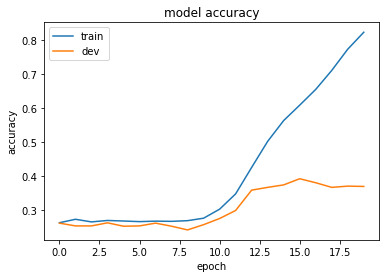

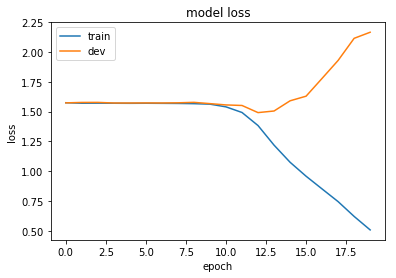

In [80]:
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.figure()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()
# summarize history for loss
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

## 4.3 -- innovate !

In [138]:
# 8 - Open question: find a model that is better on your dev set
#     (e.g: use a 1D ConvNet, use a better classifier, pretrain your lookup tables ..)
#     you will get point if the results on the test set are better: be careful of not overfitting your dev set too much..
#     Attach the output file "XXX_XXX_y_test_sst.txt" to your deliverable.

# TYPE CODE HERE
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dropout, GlobalMaxPooling1D

# get pretrained embedding weights
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=200000)
word_embed_dim = 300
dist_vocabs = set(vocabs)
embeddings = np.zeros((extended_vocab_size, word_embed_dim))
unseen = 0
for i, c in enumerate(dist_vocabs):
    encode = one_hot(c, extended_vocab_size)
    if c in w2v.word2vec.keys():
        embeddings[encode] = w2v.word2vec[c]

model = Sequential()
model.add(Embedding(input_dim=embeddings.shape[0], 
                      output_dim=word_embed_dim,
                      weights=[embeddings], # we pass our pre-trained embeddings
                      trainable=True))
model.add(Dropout(0.3))
model.add(Conv1D(filters=64, kernel_size=3, kernel_regularizer=regularizers.l2(0.01), padding='same', activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.3))
model.add(Dense(n_classes, activation='softmax'))

optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=1e-6)

model.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)
print(model.summary())

Loaded 200000 pretrained word vectors
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_29 (Embedding)     (None, None, 300)         5439300   
_________________________________________________________________
dropout_23 (Dropout)         (None, None, 300)         0         
_________________________________________________________________
conv1d_28 (Conv1D)           (None, None, 64)          57664     
_________________________________________________________________
global_max_pooling1d_15 (Glo (None, 64)                0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_43 (Dense)             (None, 5)                 325       
Total params: 5,497,289
Trainable params: 5,497,289
Non-trainable params: 0
____________________________

In [139]:
bs = 64
n_epochs = 5

history = model.fit(X_train, y_train, batch_size=bs, epochs=n_epochs, validation_data=(X_dev, y_dev))

Train on 8544 samples, validate on 1101 samples
Epoch 1/5
8544/8544 [==============================] - 23s 3ms/step - loss: 2.2488 - acc: 0.2844 - val_loss: 1.8660 - val_acc: 0.3606
Epoch 2/5
8544/8544 [==============================] - 19s 2ms/step - loss: 1.7089 - acc: 0.3826 - val_loss: 1.5958 - val_acc: 0.3878
Epoch 3/5
8544/8544 [==============================] - 19s 2ms/step - loss: 1.5065 - acc: 0.4325 - val_loss: 1.4900 - val_acc: 0.3987
Epoch 4/5
8544/8544 [==============================] - 19s 2ms/step - loss: 1.4023 - acc: 0.4652 - val_loss: 1.4625 - val_acc: 0.4114
Epoch 5/5
8544/8544 [==============================] - 19s 2ms/step - loss: 1.3212 - acc: 0.5119 - val_loss: 1.4542 - val_acc: 0.4142


In [140]:
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
pd.DataFrame(y_pred).to_csv('pretrained_conv1d_y_test_sst.txt', header=False, index=False)